# Evaluate LLM results

Install Dependencies

In [1]:
# %%capture
# !pip install datasets==2.20.0
# !pip install -U langsmith==0.1.99
# !pip install langchain_openai==0.1.22
# !pip install langchain==0.2.13
# !pip install langchain_community==0.2.12                          
# !pip install transformers==4.44.0
# !pip install termcolor==2.4.0
# !pip install accelerate==0.33.0
# !pip install pandas==2.2.2
# !pip install openpyxl==3.1.5
# !pip install python-dotenv==1.0.1
# !pip install einops==0.8.0
# !pip install wheel==0.44.0
# !pip install sentencepiece==0.2.0
# !pip install protobuf==5.27.3 #Mistral models needs this
# !pip install groq==0.10.0 #Groq models needs this
# !pip install matplotlib==3.9.2
# !pip install seaborn==0.13.2

# !pip install flash-attn==2.6.3 #Install it at the end after wheel has been installed
# !pip install anthropic==0.34.1 #Anthropic models needs this

# #Only if CPU is used
# !pip install torch==2.0.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

RunPod specific parameters

In [2]:
#For RunPod change to persistent storage directory
import os
os.chdir('/workspace')

Specify Path and Load API Keys

In [3]:
file_path ='/workspace/Example_QA_data_raw.xlsx' #Dataset generated with the help of GPT-4o
#'/Users/nikolaossourlo/Desktop/Example_QA_data_raw.xlsx' #For MacOS
#'C:/Users/soyrl/Desktop/Example_QA_data_raw.xlsx' #For Windows
# '/content/drive/My Drive/Example_QA_data_raw.xlsx' #For Google Colab
#'/home/nikolaossourlo/Example_QA_data_raw.xlsx' #For Delft Blue
# '/workspace/Example_QA_data_raw.xlsx' #For RunPod

custom_cache_dir="/workspace/cache/huggingface" #Save models here so that we don't have to download them again
#"/scratch/nikolaossourlo/cache" in Delft Blue

# Check if custom_cache_dir is defined, otherwise use default behavior
try:
    cache_dir=custom_cache_dir
except:
    cache_dir=None

from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv(dotenv_path=os.getcwd()+"/env")

# Get the OpenAI API key
openai_api_key = os.getenv('OPENAI_API_KEY_DRACO')
langsmith_api_key = os.getenv('LANGSMITH_API_KEY')

#Login to Hugging Face
from huggingface_hub import login
# Log in with your Hugging Face token
login(token=os.getenv('HF_TOKEN'))

# print(openai_api_key)
# print(langsmith_api_key)

/workspace/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Select model and name for the experiment

In [4]:
models=["meta-llama/Meta-Llama-3.1-8B-Instruct", #Takes 2.5-3mins in A4500 (20GB VRAM) and in Delft Blue
    "microsoft/Phi-3.5-mini-instruct", #Took 5mins in A40 with 48GB VRAM, 2mins in A4500 with 20GB VRAM, 3mins in Delft Blue
    "mistralai/Mistral-7B-Instruct-v0.3", #4mins in A40 with 48GB VRAM, 2.5mins in A4500 with 20GB VRAM and in Delft Blue
    "Qwen/Qwen2-7B-Instruct", #4mins in A40 with 48GB VRAM, 2 mins in A4500 with 20GB VRAM, 2.5mins in Delft Blue
    'AI-MO/NuminaMath-7B-TIR', #2.5 in A4500 with 20GB VRAM and in Delft Blue - We can also try 01-ai/Yi-Coder-9B-Chat
    'microsoft/Phi-3-mini-4k-instruct', #6 mins in RTX3090
    "google/gemma-2-9b-it", #More than 20GB of GPU memory needed - Works with A40 with 48GB VRAM (sometimes with A4500 too - 4mins) and takes ~8mins, 4.5mins in Delft Blue
    'mistralai/Mistral-Nemo-Instruct-2407', #12B parameters, 11mins in 2 RTX3090, 16mins in V100 with 32GB VRAM
    'openai/gpt-4o-mini'] #All above models need ~130GB space, the last needs ~30GB space

# Groq models are defined as: groq_website/model_name e.g. 'groq_website/llama-3.1-70b-versatile'
# OpenAI models are defined as: 'openai/model_name', e.g. 'openai/gpt-4o-mini'
# Anthropic models are defined as 'anthropic/model_name', e.g. 'anthropic/claude-3-haiku-20240307' - Couldn't use due to billing issues

# I couldn't run 'nvidia/Mistral-NeMo-Minitron-8B-Base', "hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4" (Conflicting dependencies),
# 'google/recurrentgemma-9b-it' # RecurrentGemmaForCausalLM.forward() got an unexpected keyword argument 'position_ids'

#Model to generate response to questions - 'gpt-4o-mini costs' very low ~0.01$ for 9 Q&A pairs. 
# model_name='meta-llama/Meta-Llama-3.1-8B-Instruct'

#Define model to act as a judge
judge_model='openai/gpt-4o-mini' #If used with Llama, only 0.01$ for 9 Q&A pairs for gpt-4o-mini, and 0.22$ for gpt-4o

#How the dataset will be named in Langsmith
def get_dataset_name(model_name, judge_model):
    try: #For Hugging Face models
        return "Chemical_Engineering_Evaluation_"+model_name.split('/')[1]+'_with_judge_'+judge_model
    except: #For OpenAI models
        return "Chemical_Engineering_Evaluation_"+model_name+'_with_judge_'+judge_model
    
# dataset_name=get_dataset_name(model_name, judge_model)

# try: #For Hugging Face models
#     dataset_name = "Chemical_Engineering_Evaluation_"+model_name.split('/')[1]+'_with_judge_'+judge_model
# except: #For OpenAI models
#     dataset_name = "Chemical_Engineering_Evaluation_"+model_name+'_with_judge_'+judge_model

#Define maximum number of tokes in the judge LLM output
max_output_tokens=500

#Limit of tokens in the generated response from LLM
generate_max_tokens=1000

Define prompts for custom evaluation metrics

In [5]:
# #Define prompts
# system_prompt="""
# You are an autoregressive language model that has been fine-tuned with instruction-tuning and RLHF. 
# You carefully provide accurate, factual, thoughtful, nuanced answers, and are brilliant at reasoning. If you think there might not be a correct 
# answer, you say so. Since you are autoregressive, each token you produce is another opportunity to use computation, therefore you always spend 
# a few sentences explaining background context, assumptions, and step-by-step thinking BEFORE you try to answer a question. 
# Your users are experts in chemical engineering, so they already know you're a language model and your capabilities and limitations, so don't 
# remind them of that. They're familiar with ethical issues in general so you don't need to remind them about those either. 
# Don't be verbose in your answers, but do provide details and examples where it might help the explanation. 
# Your goal is to act as a judge on if the predicted and actual answer on a given question have the same context or not. Be concise and provide
# an explanation only in case the two answers do not have the same context. 
# IMPORTANT: End your responses with the sentence: "FINAL JUDGEMENT:" followed by 'CORRECT' or 'INCORRECT' based on your evaluation.
# """

In [6]:
common_prompt="""
You are an autoregressive language model that acts as a judge in comparing a predicted vs an actual answer to a questions.
Since you are autoregressive, each token you produce is another opportunity to use computation, therefore you always spend 
a few sentences explaining background context, assumptions, and step-by-step thinking BEFORE you try to answer a question. 
Your users are experts in chemical engineering, so they already know you're a language model and your capabilities and limitations, so don't 
remind them of that. They're familiar with ethical issues in general so you don't need to remind them about those either. 
Don't be verbose in your answers, but do provide details and examples where it might help the explanation. 
""" #This is common for all prompts below

In [7]:
completeness_descr = """
Your task is to evaluate a given response with regards to completeness. The completeness metric evaluates the extent to which the question in the user's prompt is answered
in full. You can assign a score from 1 to 5, with the following interpretations:
1: There is no response.
2: No parts of a suitable answer are present.
3: Few elements of a complete answer are present.
4: Most elements of a complete answer are present.
5: The response covers all elements of a complete answer.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

relevance_descr = """
Your task is to evaluate a given response with regards to relevance. The relevance metric evaluates the amount of irrelevant information in the response considering 
the user's original question. You can assign a score from 1 to 5, with the following interpretations:
1: The response answers something else, not the user's question.
2: The response answers the user's question but the information provided is mostly irrelevant.
3: The response answers the user's question but contains more irrelevant information than relevant information.
4: The response answers the user's question, and shares a bit of irrelevant information.
5: The response answers the user's question and contains no irrelevant information.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

conciseness_descr = """
Your task is to evaluate a given response with regards to conciseness. The conciseness metric evaluates the amount of unexpected extra information in the response
considering the user's original question. You can assign a score from 1 to 5, with the following interpretations:
1: The response is too long and stops before completion or enters an infinite loop.
2: The response includes a lot of extra information and uses flowery language.
3: The response includes a lot of extra information or uses flowery language.
4: The response is short and includes a small amount of extra information.
4: The response is as short as possible while still answering the prompt.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

confidence_descr = """
Your task is to evaluate a given response with regards to confidence. The condifence metric evaluates the degree of assurance that is conveyed the response that 
the provided answer is correct. You can assign a score from 1 to 5, with the following interpretations:
1: Complete Rejection. The response makes it clear that the given answer is incorrect or that no correct answer can be provided.
2: Doubt and Disagreement. The response suggests that the answer is likely incorrect or raises significant concerns.
3: Uncertainty. The response indicates that the answer could be correct, but there is significant doubt or insufficient evidence.
4: Moderate Agreement. The response leans towards the answer being correct but acknowledges some uncertainty.
5: Full Endorsement. The reponse confidentely asserts that the given answer is correct.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

factuality_descr = """
Your task is to evaluate a given response with regards to factuality. The factuality metric evaluates the degree of hallucination contained in a response or, 
in other words, how accurate a given response is. You can assign a score from 1 to 5, with the following interpretations:
1: The response is a complete hallucination
2: The response is mostly a hallucination but does not change key information from the prompt (such as chemical identifiers).
3: The response contains large amounts of both hallucinations and factual information.
4: The response includes mostly factual information with slight hallucinations.
5: The response only includes factual information.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

judgement_descr = """
Your task is to evaluate a given response with regards to judgement. The judgment metric assesses how strongly the response implies its correctness, taking 
into account the actual accuracy of the answer. You can assign a score from 1 to 5, with the following interpretations:
1: The response confidently claims a hallucination as truth.
2: The response misinterprets information received in the prompt.
3: The response shows that the model is unsure about the answer or states that information is theoretical.
4: The response is wrong but it is made clear that the answer is wrong or that the model is unable to provide a correct answer.
5: The response is correct.
IMPORTANT: End your responses with the sentence: "FINAL SCORE:" followed by whole numbers only (1, 2, 3, 4, or 5). Do not use decimal points. This may not be disregarded!
"""

Check if GPU is available

In [8]:
import torch
print(torch.version.cuda)

12.1


Google Drive mount (If run in Colab)

In [9]:
if 'content/drive/My Drive' in file_path:
    from google.colab import drive
    drive.mount('/content/drive')

Read Excel File

In [10]:
import pandas as pd
qa=pd.read_excel(file_path) #Read Excel

Create Dataset from df

In [11]:
from datasets import Dataset
loaded_dataset=Dataset.from_pandas(qa)
# loaded_dataset = loaded_dataset.train_test_split(test_size=0.2, seed=42) #Used if going to fine-tune in part of the dataset

In [12]:
# dataset_train=loaded_dataset['train']
# dataset_test=loaded_dataset['test']

dataset_test=loaded_dataset

Create Langsmith Test Dataset

In [13]:
#https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets

from langsmith import Client

example_inputs = [(x['input'],x['output']) for x in dataset_test]
print(example_inputs)

def create_langsmith_dataset(dataset_name, example_inputs, langsmith_api_key):

    # global client
    client = Client(api_key=langsmith_api_key)

    try:
        #Load the dataset if already exists
        for existing_dataset in client.list_datasets():
            if existing_dataset.name==dataset_name:
                dataset_langsmith=existing_dataset
        # dataset_langsmith = list(client.list_examples(dataset_name=dataset_name))
        for x in dataset_langsmith:
            print("Dataset Loaded")
            break

    except: #Otherwise create it
        print("Dataset not found. Creating new dataset")
        # Storing inputs in a dataset lets us run chains and LLMs over a shared set of examples.
        dataset_langsmith = client.create_dataset(dataset_name=dataset_name,
                                                description="Q&A chemical engineering.")

        for input_prompt, output_answer in example_inputs:
            client.create_example(
                inputs={"question": input_prompt},
                outputs={"answer": output_answer},
                # metadata={"source": "Wikipedia"},
                dataset_id=dataset_langsmith.id,
            )

    return dataset_langsmith

[('What was the first appearance of process intensification in chemical engineering?', 'The first appearance fo process intensification as we know it today was marked by the paper on application of centrifugal fields, or so called "HiGee". Here centrifugal fields in zero gravity are used to enhance transfer rates.'), ('Give some examples of technologies used in process intesification.', 'Examples of process intensifications would be: rotating equipment, heat exchanger reactors, intensive mixing devices or microchannel reactors.'), ('What is the difference between general process optimization and PI?', 'General process optimization focuses on improving overal process performance through incremental changes, while process intensification aims to achieve these improvements by fundamentally changing a process.'), ('Could you give a concrete example of the distinction of PSE and PI? ', 'The example for process systems engineering comes from the middle-ages, where cold was retrieved from gol

Custom Evaluation Metrics

In [14]:
# https://docs.smith.langchain.com/old/cookbook/introduction
# https://docs.smith.langchain.com/old/evaluation/faq/custom-evaluators
from langsmith.schemas import Run, Example
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from termcolor import colored

# #Function that compares the real answer with the predicted answer of an LLM and returns 'correct' or 'incorrect' based on the evaluation
# def custom_evaluator(run: Run, example: Example) -> dict: 
#     # print("Run:",run)

#     question=run.inputs.get("inputs")['question']
#     # print("Question:",question)
#     actual_answer = example.outputs.get("answer")
#     # print("Real answer:",example.outputs.get("answer"))
#     predicted_answer = run.outputs.get("output")
#     # print("Predicted Answer:",answer)
    
#     # Check if there is output from LLM
#     if not predicted_answer:
#         print("No output from LLM")
#         return {"key": "custom_metric" , "score": 0} 
#     else:
#         # Define roles and placeholders
#         chat_template = ChatPromptTemplate.from_messages(
#           [("system", system_prompt),
#             ("user", "Question: {question}, Actual answer: {actual_answer}, Predicted answer: {predicted_answer}"),
#             # ("ai", "It's sunny and warm outside."), #Use this if we want to use few shot prompts
#           ]
#         )

#         messages = chat_template.format_messages(question=question, actual_answer=actual_answer, predicted_answer=predicted_answer)
#         # print("Messages:",messages)

#         formatted_messages = [(role, msg.content) for role, msg in zip(["system", "user"], messages)]
#         # print("Formatted messages:",formatted_messages) #[('system', 'You are an autoregressive lan....', 'user':.....)]

#         # Initialize the model and get response
#         llm = ChatOpenAI(model_name=judge_model.split('/')[1], api_key=openai_api_key, temperature=0, max_tokens=max_output_tokens, seed=42)
#         ai_response = llm.invoke(formatted_messages)

#         # Output
#         # print(colored("System message:"+ messages[0].content,'blue'))
#         print(colored("User message:"+ messages[1].content, 'green'))
#         print(colored("AI message:"+ ai_response.content,'red'))

#         #Decide what the final score is based on output
#         if "FINAL JUDGEMENT: CORRECT" in ai_response.content: 
#             score = 1
#         elif "FINAL JUDGEMENT: INCORRECT" in ai_response.content:
#             score = 0
#         else:
#             print("Invalid response from LLM:", ai_response.content)
#             score = 0

#         print("\n")
#         return {"key": "custom_metric" , "score": score} #Key is the name in the chart

In [15]:
#https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#use-a-summary-evaluator
list_of_metrics=['completeness_descr','relevance_descr','conciseness_descr','confidence_descr','factuality_descr','judgement_descr']

#Same as above for other metrics defined
def factor_evaluator(run: Run, example: Example) -> dict: 
    # print("Run:",run)

    question=run.inputs.get("inputs")['question']
    # print("Question:",question)
    actual_answer = example.outputs.get("answer")
    # print("Real answer:",example.outputs.get("answer"))
    predicted_answer = run.outputs.get("output")
    # print("Predicted Answer:",answer)
    
    # Check if there is output from LLM
    if not predicted_answer:
        print("No output from LLM")
        return {"key": "custom_metric" , "score": 0} 
    else:
        scores={} #Store scores for each metric
        descriptions={} #Store descriptions for each metric
        for metric_name in list_of_metrics: #Iterate through all metrics
            print("Evaluating based on:",metric_name)
            metric_value=common_prompt+eval(metric_name) #Get the actual description of the metric

            # Define roles and placeholders
            chat_template = ChatPromptTemplate.from_messages(
            [("system", metric_value),
                ("user", "Question: {question}, Actual answer: {actual_answer}, Predicted answer: {predicted_answer}"),
                # ("ai", "It's sunny and warm outside."), #Use this if we want to use few shot prompts
            ]
            )

            messages = chat_template.format_messages(question=question, actual_answer=actual_answer, predicted_answer=predicted_answer)
            # print("Messages:",messages)

            formatted_messages = [(role, msg.content) for role, msg in zip(["system", "user"], messages)]
            # print("Formatted messages:",formatted_messages) #[('system', 'You are an autoregressive lan....', 'user':.....)]

            # Initialize the model and get response
            llm = ChatOpenAI(model_name=judge_model.split('/')[1], api_key=openai_api_key, temperature=0, max_tokens=max_output_tokens, seed=42)
            ai_response = llm.invoke(formatted_messages)

            # Output
            # print(colored("System message:"+ messages[0].content,'blue'))
            print(colored("User message:"+ messages[1].content, 'green'))
            print(colored("AI message:"+ ai_response.content,'red'))

            #Decide what the final score is based on output
            if "FINAL SCORE:" in ai_response.content: 
                score = int(ai_response.content.split("FINAL SCORE:")[1])
            else:
                print("Invalid response from LLM:", ai_response.content)
                score = 0

            print("\n")
            scores[metric_name]=score
            print("Scores:",scores)
            descriptions[metric_name]=ai_response.content

    return {
        "results":[ #We always need 'key', 'score' pairs
            {"key": "completeness" , "score": scores['completeness_descr'],"value":descriptions['completeness_descr']},
            {"key": "relevance" , "score": scores['relevance_descr'], "value":descriptions['relevance_descr']},
            {"key": "conciseness" , "score": scores['conciseness_descr'], "value":descriptions['conciseness_descr']},
            {"key": "confidence" , "score": scores['confidence_descr'], "value":descriptions['confidence_descr']},
            {"key": "factuality" , "score": scores['factuality_descr'], "value":descriptions['factuality_descr']},
            {"key": "judgement" , "score": scores['judgement_descr'], "value":descriptions['judgement_descr']}
        ]
    }

Other evaluators from Langsmith

In [16]:
# https://docs.smith.langchain.com/old/evaluation/faq/evaluator-implementations
# https://docs.smith.langchain.com/old/evaluation/quickstart
# https://docs.smith.langchain.com/tutorials/Developers/evaluation
# from langsmith.evaluation import LangChainStringEvaluator

# eval_llm = ChatOpenAI(model_name=judge_model.split('/')[1], api_key=openai_api_key, temperature=0.0, seed=42)

# #Evaluators
# qa_evaluator = LangChainStringEvaluator("qa", config={"llm": eval_llm}) #LLM just gives 'correct' or 'incorrect' based on reference answer
# context_qa_evaluator = LangChainStringEvaluator("context_qa", config={"llm": eval_llm}) #Also uses reference context of example outputs to do the above
# cot_qa_evaluator = LangChainStringEvaluator("cot_qa", config={"llm": eval_llm}) #Same as above but with chain of thought 'reasoning'

#Prompts Used internally:

# 1) context_qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the context the question is about, and the student's answer. You are asked to score the student's answer as either CORRECT or INCORRECT, 
# based on the context.

# Example Format:
# QUESTION: question here
# CONTEXT: context the question is about here
# STUDENT ANSWER: student's answer here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer. 
# It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 


# 2) cot_qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the context the question is about, and the student's answer. You are asked to score the student's answer as either CORRECT or INCORRECT, 
# based on the context.
# Write out in a step by step manner your reasoning to be sure that your conclusion is correct. Avoid simply stating the correct answer at the outset.

# Example Format:
# QUESTION: question here
# CONTEXT: context the question is about here
# STUDENT ANSWER: student's answer here
# EXPLANATION: step by step reasoning here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer.
#  It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 


# 3) qa_evaluator: You are a teacher grading a quiz.
# You are given a question, the student's answer, and the true answer, and are asked to score the student answer as either CORRECT or INCORRECT.

# Example Format:
# QUESTION: question here
# STUDENT ANSWER: student's answer here
# TRUE ANSWER: true answer here
# GRADE: CORRECT or INCORRECT here

# Grade the student answers based ONLY on their factual accuracy. Ignore differences in punctuation and phrasing between the student answer and true answer.
#  It is OK if the student answer contains more information than the true answer, as long as it does not contain any conflicting statements. Begin! 

Alternatively, use custom prompts as shown below (and set {"prompt": PROMPT} as additional argument inside the config above)

In [17]:
# from langchain_core.prompts.prompt import PromptTemplate

# _PROMPT_TEMPLATE = """You are an expert professor specialized in chemical engineering answers to questions.
# You are grading the following question:
# {query}
# Here is the real answer:
# {answer}
# You are grading the following predicted answer:
# {result}
# Respond with CORRECT or INCORRECT:
# """

# PROMPT = PromptTemplate(
#     input_variables=["query", "result", "answer"], template=_PROMPT_TEMPLATE
# )

Define Models that Generate Responses

In [18]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.random.manual_seed(0) #Set for reproducibility

def initialize_model(model_id):
    # # Check if mps acceleration is available (For MacOS)
    # device = "mps" if torch.backends.mps.is_available() else "cpu"
    # print(f"Using device {device}")
    # model.to(device)

    # transformers.set_seed(42) #Tried for reproducibility but didn't work
    
    pipeline = transformers.pipeline( 
            "text-generation",
            model=model_id,
            model_kwargs={"torch_dtype": torch.bfloat16, "cache_dir":cache_dir},
            # trust_remote_code=True,
            device_map="auto" #Use 'cuda' if one GPU available (works in Delft Blue with 32GB VRAM) - 'auto' the alternative for distributed over all available GPUs
        )
    return pipeline

def get_model(model_id):
    """Given a model name, return the loaded model, tokenizer, and pipeline"""

    if 'openai' not in model_id and 'groq_website' not in model_id: #For Hugging Face models
        pipeline=initialize_model(model_id)

    #Returns below variables if defined, and returns None for any that are not.
    model = locals().get('model', None)
    tokenizer = locals().get('tokenizer', None)
    pipeline = locals().get('pipeline', None)

    return model, tokenizer, pipeline

In [20]:
# model, tokenizer, pipeline = get_model(model_name)

Generate Responses

In [21]:
import time

def predict(inputs: dict) -> dict:
    """Given a question, return the answer from the model"""
    
    messages = [
      # {"role": "system", "content": "You are a language model specialized in chemical engineering. Answer the question."},
      {"role": "user", "content": inputs['question']},
    ]
    # print("Prompt:",messages)
    global model_name
    # print("Model name for response generation:",model_name)

    generation_args = { 
        "max_new_tokens": max_output_tokens, 
        "return_full_text": False, 
        # "temperature": 0.0001,  #Temparature not considered from model when do_sample is False (reproducible results)
        "do_sample": False, #Selects highest probability token
      } 
    
    if 'openai' not in model_name and 'groq_website' not in model_name: #For Hugging Face models
      response=pipeline(messages, **generation_args)[0]['generated_text']
      print(model_name,':',response)

    else: 
      if 'openai' in model_name:
        try:
          import openai
          from langsmith.wrappers import wrap_openai

          # print("Using OpenAI models for generating the response")
                  
          # Define OpenAI client
          openai_client = wrap_openai(openai.Client(api_key=openai_api_key))
          
          response = openai_client.chat.completions.create(messages=messages, temperature=0, model=model_name.split('/')[1],  seed=42) 
          # print("Response:",response.choices[0].message.content)
          response=response.choices[0].message.content #That's the response without formatting
          time.sleep(5)
        except Exception as e:
          print("Error:",e)
          print("OpenAI Model ID:",model_name)
      elif 'groq_website' in model_name:
        try:
          from groq import Groq

          client = Groq()
          actual_model_name=model_name.split('/')[1]
          response = client.chat.completions.create(
              model=actual_model_name,
              max_tokens=generate_max_tokens,
              temperature=0,
              messages=messages)
          # print("Response from Groq:",response.choices[0].message.content)
        except Exception as e:
          print("Error:",e)
          print("Groq Model ID:",model_name)

    return {"output": response}

In [22]:
def plot_figures_metrics(metric_names, metric_values, model_name, judge_model):
    #Plot figures with distributions of metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Colors for separate plots
    colors = sns.color_palette("Set3", len(metric_names))

    fig, axes = plt.subplots(len(metric_names), 1, figsize=(10, 18))
    plt.subplots_adjust(hspace=0.6, top=0.94) #hspace=1 if 'values' below every plot, 'top' sets distance between title and subfigures

    # Set a title for all subplots
    fig.suptitle('Metric Distributions', fontsize=16)

    # Define the bin edges explicitly to ensure consistency
    bin_edges = np.arange(0.0, 5.6, 0.2)  # Adjust to cover the range 1-5 with bins of width 1

    # Plotting each metric in separate subplots
    for i, (metric_name, values) in enumerate(zip(metric_names, metric_values)):
        sns.histplot(values, bins=bin_edges, color=colors[i], ax=axes[i], kde=False)
        axes[i].set_title(f'{metric_name}')
        axes[i].set_xlim(0, 5.5) #Keep 0 in case of errors
        # axes[i].set_xlabel('Values')
        axes[i].set_ylabel('Frequency')
        axes[i].set_yticks(range(0, 11, 5))  # Set y-ticks at intervals of 5

        # Hide x-axis labels and ticks for all but the last subplot
        if i < len(metric_names) - 1:
            axes[i].set_xlabel('')
        else:
            axes[i].set_xlabel('Values')

    # Save the plot with the judge and model names
    plt.savefig(str(judge_model.split('/')[1])+'_judge_with_'+str(model_name).replace("/","_")+'_metric_distributions.png')


    # Combined plot with all metrics in one plot
    plt.figure(figsize=(10, 8))
    for i, (metric_name, values) in enumerate(zip(metric_names, metric_values)):
        sns.histplot(values, bins=bin_edges, color=colors[i], label=metric_name, kde=False, alpha=0.6)

    plt.title('Combined Metric Distributions')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.xlim(0, 5.5)

    # Save the plot with the judge and model names
    plt.savefig(str(judge_model.split("/")[1])+'_judge_with_'+str(model_name).replace("/","_")+'_combined_metric_distributions.png')

    return

Perform the Evaluation over all models

Dataset Loaded


Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.84s/it]


Model: microsoft/Phi-3-mini-4k-instruct loaded
View the evaluation results for experiment: 'openai/gpt-4o-mini_judge_with_microsoft/Phi-3-mini-4k-instruct-1f8e8a7c' at:
https://smith.langchain.com/o/42866633-791c-5d79-833d-4e624439c57c/datasets/76d70f8a-ffd9-4189-a68c-fbef9ae185eb/compare?selectedSessions=dc462e6b-fadc-4bfe-ad0e-5c41ef970224




0it [00:00, ?it/s]You are not running the flash-attention implementation, expect numerical differences.


meta-llama/Meta-Llama-3.1-8B-Instruct :  Membranes in chemical reactor systems serve several critical functions, including:


1. **Separation**: Membranes can separate reactants from products or separate different products from each other based on size, charge, or chemical affinity.

2. **Purification**: They can purify reactants by removing impurities or by-products that may inhibit the reaction or contaminate the final product.

3. **Concentration**: Membranes can concentrate reactants or products by selectively allowing certain molecules to pass through while retaining others.

4. **Control of Reaction Environment**: By controlling the permeability of the membrane, the reaction environment can be adjusted to optimize reaction conditions.

5. **Energy Efficiency**: Membranes can reduce the energy requirements of a process by operating at lower temperatures or pressures compared to traditional separation methods.

6. **Safety**: They can contain hazardous substances within the reactor

1it [03:33, 213.65s/it]

Evaluating based on: completeness_descr


7it [03:36, 11.76s/it] 

User message:Question: How can I separate my liquid-liquid mixture using a reactive separation method?, Actual answer: Some options to consider are reactive extraction or membrane reactors. The best unit to separate the mixture depends on the characteristics of the components., Predicted answer:  To separate a liquid-liquid mixture using a reactive separation method, you can employ a process called liquid-liquid extraction, which involves a chemical reaction that selectively transfers one or more components from the mixture into a different phase. Here's a step-by-step guide to perform this separation:


1. Identify the components of your liquid-liquid mixture and their chemical properties.

2. Choose a suitable solvent that reacts with one of the components to form a product that is immiscible with the original solvent.

3. Mix the liquid-liquid mixture with the chosen solvent in a separatory funnel.

4. Shake the separatory funnel gently to allow the reaction to occur and the compone

8it [03:38,  8.65s/it]

User message:Question: How can I separate my liquid-liquid mixture using a reactive separation method?, Actual answer: Some options to consider are reactive extraction or membrane reactors. The best unit to separate the mixture depends on the characteristics of the components., Predicted answer:  To separate a liquid-liquid mixture using a reactive separation method, you can employ a process called liquid-liquid extraction, which involves a chemical reaction that selectively transfers one or more components from the mixture into a different phase. Here's a step-by-step guide to perform this separation:


1. Identify the components of your liquid-liquid mixture and their chemical properties.

2. Choose a suitable solvent that reacts with one of the components to form a product that is immiscible with the original solvent.

3. Mix the liquid-liquid mixture with the chosen solvent in a separatory funnel.

4. Shake the separatory funnel gently to allow the reaction to occur and the compone

9it [03:58, 26.49s/it]


Total time taken: 239.8040747642517
--------------------------------------------------


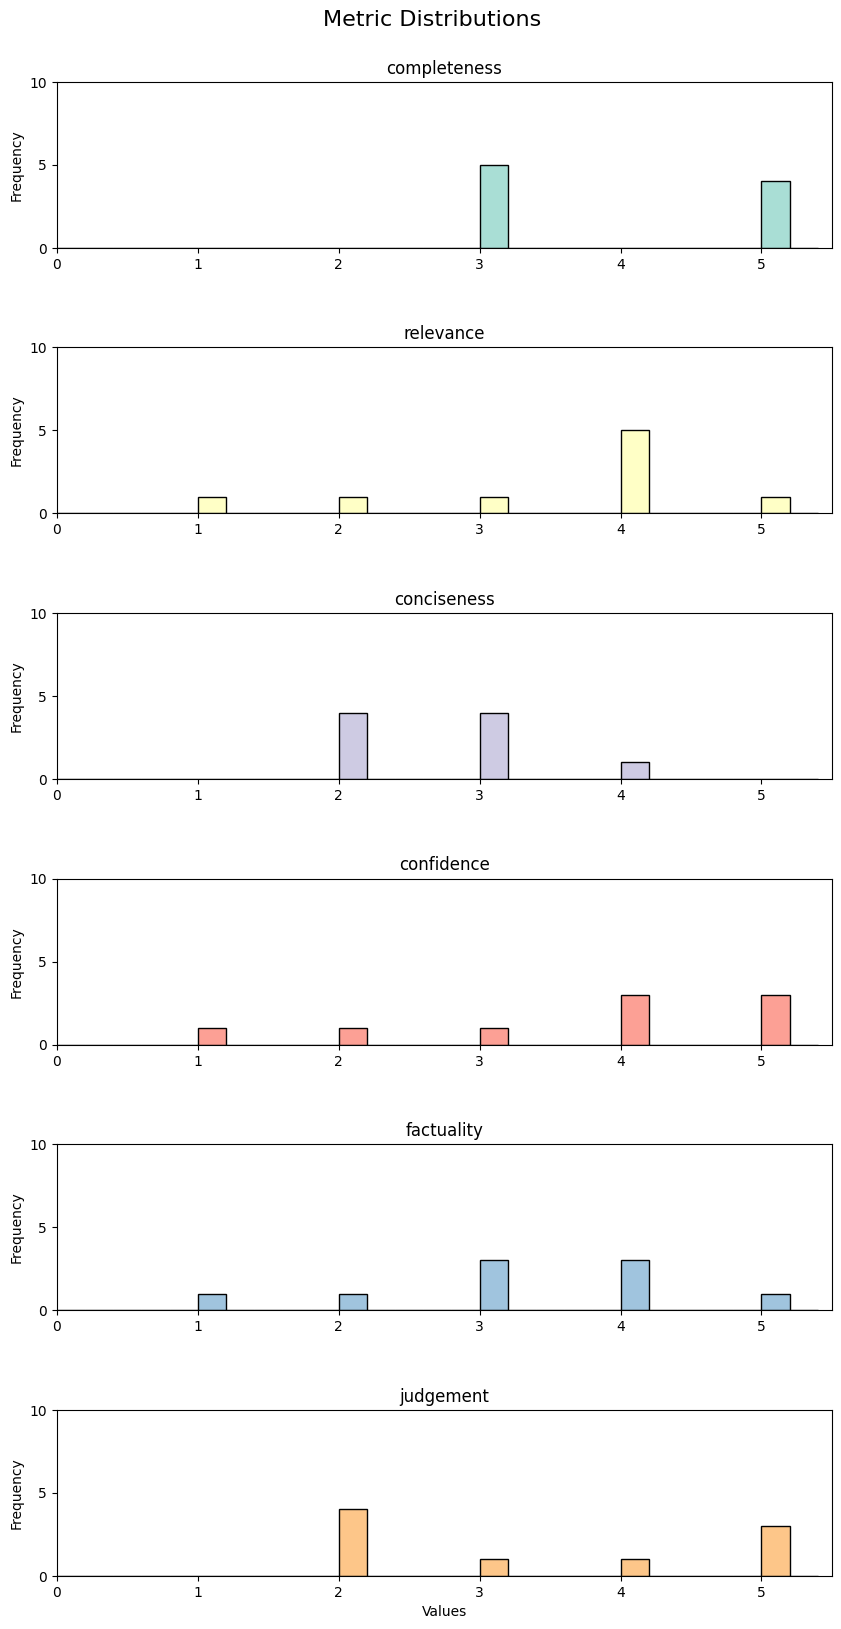

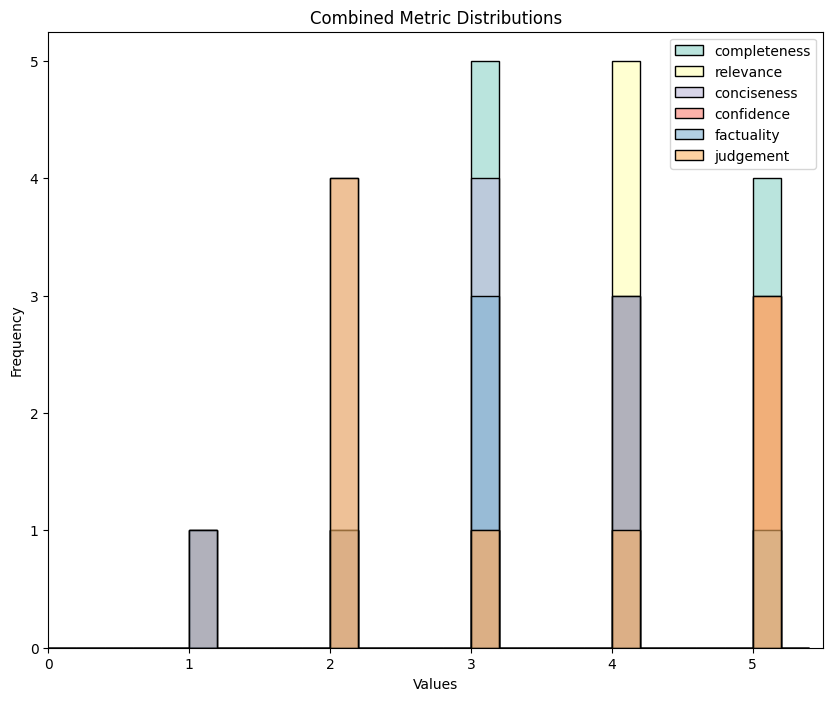

In [23]:
#https://python.langchain.com/v0.2/docs/integrations/chat/openai/
from langsmith.evaluation import evaluate

#Initialize models
for model_id in models:
    
    dataset_name=get_dataset_name(model_id, judge_model)
    dataset_langsmith=create_langsmith_dataset(dataset_name, example_inputs, langsmith_api_key)
    model, tokenizer, pipeline = get_model(model_id)
    print(f"Model: {model_id} loaded")

    # Evaluation
    begin=time.time()

    evaluation_results=evaluate(
        predict, #Function that call our LLM and returns its output
        data=dataset_langsmith.name, #dataset_langsmith_name, #JUST DATASET_NAME NOT WORKING WHEN CREATING NEW 
        evaluators=[factor_evaluator #custom_evaluator, qa_evaluator, context_qa_evaluator, cot_qa_evaluator, 
                    ], #Evaluators to use
        # metadata={"revision_id": "the version of your pipeline you are testing"},
        experiment_prefix=str(judge_model)+'_judge_with_'+str(model_id) # A prefix for your experiment names to easily identify them
    )

    end=time.time()
    print("Total time taken:",end-begin) #Takes ~25mins on V100 GPU (probably CPU though) for quantized

    #Extract metrics and save to df
    #Initialize empty df to be filled with results
    results_df=pd.DataFrame()

    #https://docs.smith.langchain.com/tutorials/Developers/evaluation
    list_of_questions=[x['example'].inputs['question'] for x in evaluation_results]
    list_of_answers=[x['example'].outputs['answer'] for x in evaluation_results]
    list_of_predicted_answers=[x['run'].outputs['output'] for x in evaluation_results]

    #Fill the df with the results
    results_df['questions']=list_of_questions
    results_df['answers']=list_of_answers
    results_df['predicted_answers']=list_of_predicted_answers

    all_runs_metrics=[x['evaluation_results']['results'] for x in evaluation_results] #list of lists
    all_metric_values=[[{x[i].key: x[i].score} for x in all_runs_metrics] for i in range(len(list_of_metrics))] #List of all completeness scores

    #Check if all keys have the same metric name. 
    same_metric= [all(list(d.keys())[0] == list(sublist[0].keys())[0] for d in sublist) for sublist in all_metric_values]
    assert [True]*len(same_metric)==same_metric

    metric_names=[key for i in range(len(all_metric_values)) for key in all_metric_values[i][0].keys()]
    metric_values=[[list(x.values())[0] for x in all_metric_values[i]] for i in range(len(all_metric_values))]
    
    all_metric_prompts=[[{x[i].key:x[i].value} for x in all_runs_metrics] for i in range(len(list_of_metrics))]
    metric_prompts=[[list(x.values())[0] for x in all_metric_prompts[i]] for i in range(len(all_metric_prompts))]

    # Adding columns to DataFrame
    for col_name, col_values,col_prompts in zip(metric_names, metric_values,metric_prompts):
        results_df[col_name] = col_values
        results_df[col_name+'_prompt'] = col_prompts

    #Save results to Excel
    results_df.to_excel("results_"+str(judge_model.split('/')[1])+'_judge_with_'+str(model_id).replace("/","_")+".xlsx",index=False)

    #Plot figures with distributions of metrics
    plot_figures_metrics(metric_names, metric_values, model_id, judge_model)

    # Clear VRAM at the end of each iteration
    del model, tokenizer, pipeline
    torch.cuda.empty_cache()

    print('-'*100)

Extract metrics and save to df and to png

In [ ]:
# #Initialize empty df to be filled with results
# results_df=pd.DataFrame()

In [ ]:
# #https://docs.smith.langchain.com/tutorials/Developers/evaluation
# list_of_questions=[x['example'].inputs['question'] for x in evaluation_results]
# list_of_questions

In [ ]:
# list_of_answers=[x['example'].outputs['answer'] for x in evaluation_results]
# list_of_answers

In [ ]:
# list_of_predicted_answers=[x['run'].outputs['output'] for x in evaluation_results]
# list_of_predicted_answers

In [ ]:
# #Fill the df with the results
# results_df['questions']=list_of_questions
# results_df['answers']=list_of_answers
# results_df['predicted_answers']=list_of_predicted_answers

In [ ]:
# all_runs_metrics=[x['evaluation_results']['results'] for x in evaluation_results] #list of lists
# # all_runs_metrics

In [ ]:
# all_metric_values=[[{x[i].key: x[i].score} for x in all_runs_metrics] for i in range(len(list_of_metrics))] #List of all completeness scores
# # all_metric_values

In [ ]:
# #Check if all keys have the same metric name. 
# same_metric= [all(list(d.keys())[0] == list(sublist[0].keys())[0] for d in sublist) for sublist in all_metric_values]
# assert [True]*len(same_metric)==same_metric

In [ ]:
# metric_names=[key for i in range(len(all_metric_values)) for key in all_metric_values[i][0].keys()]
# metric_names

In [ ]:
# metric_values=[[list(x.values())[0] for x in all_metric_values[i]] for i in range(len(all_metric_values))]
# metric_values

In [ ]:
# # Adding columns to DataFrame
# for col_name, col_values in zip(metric_names, metric_values):
#     results_df[col_name] = col_values

# #Save results to Excel
# results_df.to_excel("results_"+str(judge_model.split('/')[1])+'_judge_with_'+str(model_name).replace("/","_")+".xlsx",index=False)

In [ ]:
# def plot_figures_metrics(metric_names, metric_values, model_name, judge_model):
#     #Plot figures with distributions of metrics
#     import matplotlib.pyplot as plt
#     import seaborn as sns
#     import numpy as np

#     # Colors for separate plots
#     colors = sns.color_palette("Set3", len(metric_names))

#     fig, axes = plt.subplots(len(metric_names), 1, figsize=(10, 18))
#     plt.subplots_adjust(hspace=0.6, top=0.94) #hspace=1 if 'values' below every plot, 'top' sets distance between title and subfigures

#     # Set a title for all subplots
#     fig.suptitle('Metric Distributions', fontsize=16)

#     # Define the bin edges explicitly to ensure consistency
#     bin_edges = np.arange(0.0, 5.6, 0.2)  # Adjust to cover the range 1-5 with bins of width 1

#     # Plotting each metric in separate subplots
#     for i, (metric_name, values) in enumerate(zip(metric_names, metric_values)):
#         sns.histplot(values, bins=bin_edges, color=colors[i], ax=axes[i], kde=False)
#         axes[i].set_title(f'{metric_name}')
#         axes[i].set_xlim(0, 5.5) #Keep 0 in case of errors
#         # axes[i].set_xlabel('Values')
#         axes[i].set_ylabel('Frequency')
#         axes[i].set_yticks(range(0, 11, 5))  # Set y-ticks at intervals of 5

#         # Hide x-axis labels and ticks for all but the last subplot
#         if i < len(metric_names) - 1:
#             axes[i].set_xlabel('')
#         else:
#             axes[i].set_xlabel('Values')

#     # Save the plot with the judge and model names
#     plt.savefig(str(judge_model.split('/')[1])+'_judge_with_'+str(model_name).replace("/","_")+'_metric_distributions.png')


#     # Combined plot with all metrics in one plot
#     plt.figure(figsize=(10, 8))
#     for i, (metric_name, values) in enumerate(zip(metric_names, metric_values)):
#         sns.histplot(values, bins=bin_edges, color=colors[i], label=metric_name, kde=False, alpha=0.6)

#     plt.title('Combined Metric Distributions')
#     plt.xlabel('Values')
#     plt.ylabel('Frequency')
#     plt.legend()
#     plt.xlim(0, 5.5)

#     # Save the plot with the judge and model names
#     plt.savefig(str(judge_model.split("/")[1])+'_judge_with_'+str(model_name).replace("/","_")+'_combined_metric_distributions.png')

For real-time inference (below implementation only for meta-llama/Meta-Llama-3.1-8B-Instruct)

In [ ]:
# from transformers import AutoModelForCausalLM, AutoTokenizer
# import torch
# # del pipeline #Otherwise too much memory is used

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name,device_map='auto')

# #Example of real-time response generation
# messages=[{"role": "user", "content": "What is the chemical formula of water?"}]

# inputs_tokenized = tokenizer.apply_chat_template(
#     messages,
#     tokenize=True,
#     add_generation_prompt=True,
#     return_tensors="pt",
#     return_dict=True,
# ).to("cuda")

# input_ids = inputs_tokenized['input_ids']

# # Generate tokens one by one
# max_length = 256
# output_ids = input_ids
# for _ in range(256):
#     outputs = model.generate(
#         output_ids,
#         max_new_tokens=1,
#         do_sample=True,
#         top_k=50,
#         pad_token_id=tokenizer.eos_token_id
#     )
#     new_token_id = outputs[0, -1].item()
#     if new_token_id == tokenizer.eos_token_id:
#         break
#     output_ids = torch.cat([output_ids, outputs[:, -1:]], dim=1)
#     new_token = tokenizer.decode(new_token_id, skip_special_tokens=True)
#     print(new_token, end="", flush=True)

# print()

Notes: Non-reproducible results, even when seed set (https://platform.openai.com/docs/api-reference/chat/create#chat-create-seed), temperature=0 (top_p should not change when we changed temperature - smaller values result in more constrained and focused response - https://medium.com/@rasithbm/chatopenai-parameters-83bef49f6384)